In [2]:
import numpy as np
import pandas as pd
import pickle, os, csv, math, time, joblib
from joblib import Parallel, delayed
import datetime as dt
from datetime import date, datetime, timedelta
from collections import Counter
import copy as cp
import tqdm
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import log_loss, f1_score, precision_score, recall_score, accuracy_score
#import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
import collections 
#import shap
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression
np.seterr(all="ignore")
import matplotlib.pyplot as plt
import tqdm
import math
import statsmodels.api as sm
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import json
import util as util_fqi
import sys
sys.path.append('models/')
from lmmfqi import LMMFQIagent
from fqi import FQIagent
from cfqi import CFQIagent

In [3]:
train_tuples, test_tuples = util_fqi.generate_tuples()

100%|██████████| 100/100 [00:01<00:00, 66.87it/s]


/Users/aishwaryamandyam/anaconda3/envs/research/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

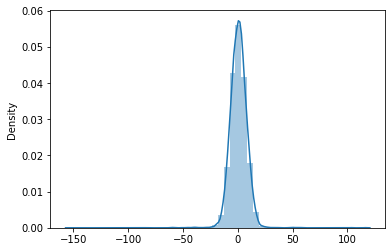

In [6]:
rewards = [x[3] for x in train_tuples]
sns.distplot(rewards)

In [ ]:
fqi_agent = FQIagent(train_tuples=train_tuples, test_tuples=test_tuples)
Q_dist = fqi_agent.runFQI(repeats=1)
plt.plot(Q_dist, label= "FQI")
plt.xlabel("Iteration")
plt.ylabel("Q Estimate")
plt.legend()
plt.show()

In [ ]:
cfqi_agent = CFQIagent(train_tuples=train_tuples, test_tuples=test_tuples)
Q_dist = cfqi_agent.runFQI(repeats=1)
plt.plot(Q_dist, label= "CFQI")
plt.xlabel("Iteration")
plt.ylabel("Q Estimate")
plt.legend()
plt.show()

In [ ]:
lmm_agent = LMMFQIagent(train_tuples=train_tuples, test_tuples=test_tuples)
Q_dist = lmm_agent.runFQI(repeats=1)
plt.plot(Q_dist, label= "LMMFQI")
plt.xlabel("Iteration")
plt.ylabel("Q Estimate")
plt.legend()
plt.show()

In [ ]:
# Test out on each test tuple
# FQI, CFQI, LMMFQI, Oracle, Random
algos = ['fqi', 'cfqi', 'lmmfqi', 'oracle', 'random']
overall_reward = {}
mu, sigma = 0, 4
for alg in algos:
    overall_reward[alg] = []
    
raw_fqi = []
raw_lmmfqi = []
raw_cfqi = []
    
for k, pat in enumerate(tqdm.tqdm(range(util_fqi.num_patients))):
    flip = np.random.choice(2)
    if flip == 0:
        ds = 'foreground'
    else:
        ds = 'background'
    
    # Generate a random initial state
    s = np.random.normal(mu, sigma, (10, 1))
    
    val_rewards = {}
    for alg in algos:
        val_rewards[alg] = []
    
    
    # Generate all of the tuples for this patient
    for i in range(util_fqi.num_samples):
        s = s.T
        # FQI agent
        fqi_action = fqi_agent.piE.predict(s)
        raw_fqi.append(fqi_action)
        #if fqi_action[0] > 3:
        #    fqi_action[0] = 3
        fqi_action = util_fqi.actions[round(fqi_action[0])]
        fqi_action = np.reshape(fqi_action, (2, 1))
        s_a = np.concatenate((s.T, fqi_action))
        val_rewards['fqi'].append(np.dot(util_fqi.reward_function.T, s_a)[0])


        # CFQI agent
        cfqi_action = cfqi_agent.piE.predict(s)
        raw_cfqi.append(cfqi_action)
        #if cfqi_action[0] > 3:
        #    cfqi_action[0] = 3
        cfqi_action = util_fqi.actions[round(cfqi_action[0])]
        cfqi_action = np.reshape(cfqi_action, (2, 1))
        s_a = np.concatenate((s.T, cfqi_action))
        val_rewards['cfqi'].append(np.dot(util_fqi.reward_function.T, s_a)[0])
        
        # LMMFQI agent
        lmmfqi_action = lmm_agent.piE.predict(s)
        raw_lmmfqi.append(lmmfqi_action)
        #if lmmfqi_action[0] > 3:
        #    lmmfqi_action[0] = 3
        lmmfqi_action = util_fqi.actions[round(lmmfqi_action[0])]
        lmmfqi_action = np.reshape(lmmfqi_action, (2, 1))
        s_a = np.concatenate((s.T, lmmfqi_action))
        val_rewards['lmmfqi'].append(np.dot(util_fqi.reward_function.T, s_a)[0])
        


        # Oracle
        all_rewards = []
        for j, a in enumerate(util_fqi.actions):
            a = np.asarray(a)
            a = np.reshape(a, (2, 1))
            s_a = np.concatenate((s.T, a))
            reward = np.dot(util_fqi.reward_function.T, s_a)
            all_rewards.append(reward)

        all_rewards = np.asarray(all_rewards)
        oracle_action = util_fqi.actions[np.argmax(all_rewards)]
        val_rewards['oracle'].append(np.max(all_rewards))


        # Random action
        random_action = np.asarray(util_fqi.actions[np.random.choice(3)])
        random_action = np.reshape(random_action, (2, 1))
        s_a = np.concatenate((s.T, random_action))
        val_rewards['random'].append(np.dot(util_fqi.reward_function.T, s_a)[0])
        
        if ds == 'foreground':
            t_m = util_fqi.transition_foreground
        else:
            t_m = util_fqi.transition_background
        ns = np.matmul(s_a.T, t_m) / np.linalg.norm(np.matmul(s_a.T, t_m), ord=2)
        ns = np.add(ns, np.random.normal(0, 0.5, (1, 10))) # Add noise
        s = ns.T
    
    plt.title("Rewards for " + ds + " trajectory: " + str(k))
    plt.xlabel("Step")
    plt.ylabel("Cumulative Reward")
    x = [i for i in range(util_fqi.num_samples)]
    rewards_fqi = util_fqi.cumulative_reward(val_rewards['fqi'])
    overall_reward['fqi'].append(rewards_fqi[-1])
    rewards_cfqi = util_fqi.cumulative_reward(val_rewards['cfqi'])
    overall_reward['cfqi'].append(rewards_cfqi[-1])
    rewards_lmmfqi = util_fqi.cumulative_reward(val_rewards['lmmfqi'])
    overall_reward['lmmfqi'].append(rewards_lmmfqi[-1])
    rewards_oracle = util_fqi.cumulative_reward(val_rewards['oracle'])
    overall_reward['oracle'].append(rewards_oracle[-1])
    rewards_random = util_fqi.cumulative_reward(val_rewards['random'])
    overall_reward['random'].append(rewards_random[-1])

    plt.plot(x, rewards_fqi, label="FQI")
    plt.plot(x, rewards_lmmfqi, label='CFQI')
    plt.plot(x, rewards_cfqi, label='LMMFQI')
    plt.plot(x, rewards_oracle, label='Oracle')
    plt.plot(x, rewards_random, label='Random')
    plt.legend()
    plt.show()

# Plots
* It seems like LMMFQI, CFQI and FQI all predict actions between 1 and 1.5 pretty frequently. 

In [ ]:
sns.stripplot(raw_lmmfqi)

In [ ]:
sns.stripplot(raw_cfqi)

In [ ]:
sns.stripplot(raw_fqi)

In [ ]:
def subtract(a, b):
    return [b_i - a_i for a_i, b_i in zip(a, b)]

In [ ]:
plt.title("Cumulative Reward across patients and algorithms")
sns.stripplot(subtract(overall_reward['oracle'], overall_reward['fqi']), color='r', label='Oracle - FQI')
sns.stripplot(subtract(overall_reward['oracle'], overall_reward['cfqi']), color='g', label='Oracle - CFQI')
sns.stripplot(subtract(overall_reward['oracle'], overall_reward['lmmfqi']), color='y', label='Oracle - LMMFQI')
sns.stripplot(subtract(overall_reward['oracle'], overall_reward['random']), color='b', label='Oracle - Random')
#sns.stripplot(overall_reward['oracle'], color='m', label="Oracle")
plt.legend()
plt.xlabel("Cumulative Reward")